In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [47]:
stocks = ['GOOGL']

end_date = pd.Timestamp.now().strftime('%Y-%m-%d')
start_date = (pd.Timestamp.now() - pd.Timedelta(days=10*365)).strftime('%Y-%m-%d')

print(f"Downloading data from {start_date} to {end_date}")
print("Stocks:", stocks)

stock_data = {}
for symbol in stocks:
    try:
        data = yf.download(symbol, start=start_date, end=end_date)
        stock_data[symbol] = data
        print(f"✅ Downloaded {symbol}: {len(data)} records")
    except Exception as e:
        print(f"❌ Failed to download {symbol}: {e}")

print(f"\nSuccessfully downloaded {len(stock_data)} stocks")

Stocks: ['GOOGL']


[*********************100%***********************]  1 of 1 completed

✅ Downloaded GOOGL: 2512 records

Successfully downloaded 1 stocks


In [48]:
def calculate_technical_indicators(df):
    indicators = pd.DataFrame(index=df.index)
    
    indicators['close'] = df['Close']
    indicators['returns'] = df['Close'].pct_change()
    indicators['log_returns'] = np.log(df['Close'] / df['Close'].shift(1))
    
    indicators['volatility_5'] = indicators['returns'].rolling(5).std()
    indicators['volatility_10'] = indicators['returns'].rolling(10).std()
    indicators['volatility_20'] = indicators['returns'].rolling(20).std()
    
    indicators['sma_5'] = df['Close'].rolling(5).mean()
    indicators['sma_10'] = df['Close'].rolling(10).mean()
    indicators['sma_20'] = df['Close'].rolling(20).mean()
    indicators['sma_50'] = df['Close'].rolling(50).mean()
  
    
    # RSI
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    indicators['rsi'] = 100 - (100 / (1 + rs))
    
    # Volume indicators
    indicators['volume'] = df['Volume']
    indicators['volume_sma_20'] = df['Volume'].rolling(20).mean()
    
    # High-Low spread
    indicators['hl_spread'] = (df['High'] - df['Low']) / df['Close']
    
    return indicators

all_indicators = {}
for symbol, data in stock_data.items():
    indicators = calculate_technical_indicators(data)
    all_indicators[symbol] = indicators
    print(f"Calculated indicators for {symbol}")

print("Technical indicators calculated for all stocks")

Calculated indicators for GOOGL
Technical indicators calculated for all stocks


In [55]:
def create_market_features(all_indicators):

    market_features = pd.DataFrame()

    returns_df = pd.DataFrame({symbol: indicators['returns'] 
                              for symbol, indicators in all_indicators.items()})
    market_features['market_return'] = returns_df.mean(axis=1)
    market_features['market_return_std'] = returns_df.std(axis=1)

    # Market volatility
    vol_df = pd.DataFrame({symbol: indicators['volatility_20'] 
                          for symbol, indicators in all_indicators.items()})
    market_features['market_volatility'] = vol_df.mean(axis=1)
    market_features['market_vol_dispersion'] = vol_df.std(axis=1)
    
    # Correlation-based features
    market_features['avg_correlation'] = returns_df.rolling(60).corr().groupby(level=0).mean().mean(axis=1)
    
    # Market momentum
    rsi_df = pd.DataFrame({symbol: indicators['rsi'] 
                          for symbol, indicators in all_indicators.items()})
    market_features['market_rsi'] = rsi_df.mean(axis=1)
        
    # Market stress indicators
    market_features['market_stress'] = (market_features['market_volatility'] > 
                                       market_features['market_volatility'].rolling(252).quantile(0.8)).astype(int)
    
    return market_features.fillna(0)

market_df = create_market_features(all_indicators)
print(f"Market features created with shape: {market_df.shape}")
print("\nMarket features:")
print(market_df.columns.tolist())

Market features created with shape: (2512, 7)

Market features:
['market_return', 'market_return_std', 'market_volatility', 'market_vol_dispersion', 'avg_correlation', 'market_rsi', 'market_stress']


In [56]:
market_df

,market_return,market_return_std,market_volatility,market_vol_dispersion,avg_correlation,market_rsi,market_stress
Date,,,,,,,
2015-06-19,0.000000,0.0,0.000000,0.0,0.0,0.000000,0
2015-06-22,0.003874,0.0,0.000000,0.0,0.0,0.000000,0
2015-06-23,0.006629,0.0,0.000000,0.0,0.0,0.000000,0
2015-06-24,-0.008555,0.0,0.000000,0.0,0.0,0.000000,0
2015-06-25,-0.001110,0.0,0.000000,0.0,0.0,0.000000,0
...,...,...,...,...,...,...,...
2025-06-09,0.015104,0.0,0.017806,0.0,1.0,64.737696,0
2025-06-10,0.014254,0.0,0.016453,0.0,1.0,72.427336,0
2025-06-11,-0.006999,0.0,0.016713,0.0,1.0,65.135126,0


In [57]:
feature_columns = [
    'market_return', 'market_return_std', 'market_volatility', 
    'market_vol_dispersion', 'avg_correlation', 'market_rsi',
]

features_df = market_df[feature_columns].dropna()

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_df)
scaled_features_df = pd.DataFrame(scaled_features, 
                                 columns=feature_columns, 
                                 index=features_df.index)

print(f"Scaled features shape: {scaled_features_df.shape}")
print(f"Date range: {scaled_features_df.index[0]} to {scaled_features_df.index[-1]}")

print("\nFeature Statistics (after scaling):")
print(scaled_features_df.describe())

Scaled features shape: (2512, 6)
Date range: 2015-06-19 00:00:00 to 2025-06-13 00:00:00

Feature Statistics (after scaling):
       market_return  market_return_std  market_volatility  \
count   2.512000e+03             2512.0       2.512000e+03   
mean   -2.121445e-18                0.0      -4.525750e-17   
std     1.000199e+00                0.0       1.000199e+00   
min    -6.380938e+00                0.0      -2.224270e+00   
25%    -4.704221e-01                0.0      -7.460168e-01   
50%     1.564014e-02                0.0      -1.722776e-01   
75%     4.918457e-01                0.0       5.466829e-01   
max     8.799551e+00                0.0       5.232260e+00   

       market_vol_dispersion  avg_correlation    market_rsi  
count                 2512.0     2.512000e+03  2.512000e+03  
mean                     0.0    -5.883475e-16  3.394312e-17  
std                      0.0     1.000199e+00  1.000199e+00  
min                      0.0    -6.392704e+00 -3.308793e+00  
25%   

In [58]:
def find_optimal_clusters(data, max_clusters=15):
    
    methods_results = {}
    
    # Method 1: Elbow method (Inertia)
    inertias = []
    silhouette_scores = []
    aic_scores = []
    bic_scores = []
    
    K_range = range(2, max_clusters + 1)
    
    for k in K_range:
        # K-Means
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)
        
        # Silhouette Score
        silhouette_avg = silhouette_score(data, kmeans.labels_)
        silhouette_scores.append(silhouette_avg)
        
        # Gaussian Mixture Model for AIC/BIC
        gmm = GaussianMixture(n_components=k, random_state=42)
        gmm.fit(data)
        aic_scores.append(gmm.aic(data))
        bic_scores.append(gmm.bic(data))
    
    return {
        'k_range': K_range,
        'inertias': inertias,
        'silhouette_scores': silhouette_scores,
        'aic_scores': aic_scores,
        'bic_scores': bic_scores
    }

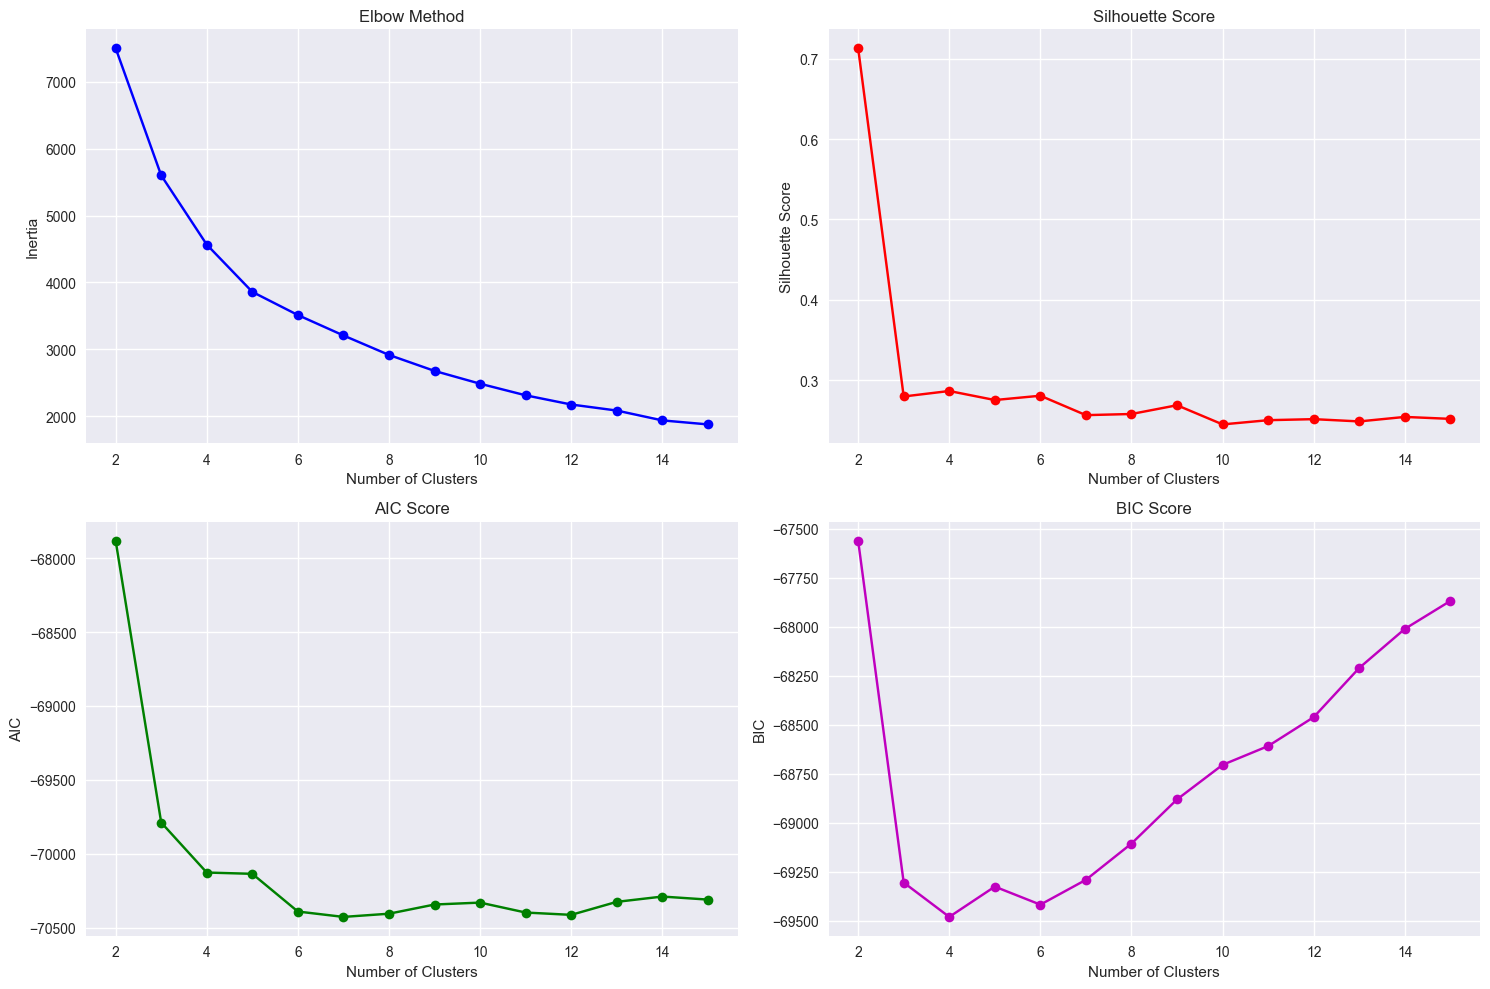

Best k by Silhouette Score: 2
Best k by AIC: 7
Best k by BIC: 4


In [59]:
cluster_results = find_optimal_clusters(scaled_features)

# Plot results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Elbow method
axes[0,0].plot(cluster_results['k_range'], cluster_results['inertias'], 'bo-')
axes[0,0].set_title('Elbow Method')
axes[0,0].set_xlabel('Number of Clusters')
axes[0,0].set_ylabel('Inertia')
axes[0,0].grid(True)

# Silhouette Score
axes[0,1].plot(cluster_results['k_range'], cluster_results['silhouette_scores'], 'ro-')
axes[0,1].set_title('Silhouette Score')
axes[0,1].set_xlabel('Number of Clusters')
axes[0,1].set_ylabel('Silhouette Score')
axes[0,1].grid(True)

# AIC
axes[1,0].plot(cluster_results['k_range'], cluster_results['aic_scores'], 'go-')
axes[1,0].set_title('AIC Score')
axes[1,0].set_xlabel('Number of Clusters')
axes[1,0].set_ylabel('AIC')
axes[1,0].grid(True)

# BIC
axes[1,1].plot(cluster_results['k_range'], cluster_results['bic_scores'], 'mo-')
axes[1,1].set_title('BIC Score')
axes[1,1].set_xlabel('Number of Clusters')
axes[1,1].set_ylabel('BIC')
axes[1,1].grid(True)

plt.tight_layout()
plt.show()

# Find best k
best_k_silhouette = cluster_results['k_range'][np.argmax(cluster_results['silhouette_scores'])]
best_k_aic = cluster_results['k_range'][np.argmin(cluster_results['aic_scores'])]
best_k_bic = cluster_results['k_range'][np.argmin(cluster_results['bic_scores'])]

print(f"Best k by Silhouette Score: {best_k_silhouette}")
print(f"Best k by AIC: {best_k_aic}")
print(f"Best k by BIC: {best_k_bic}")

In [60]:
optimal_k = 6
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(scaled_features)

gmm = GaussianMixture(n_components=optimal_k, random_state=42)
gmm_labels = gmm.fit_predict(scaled_features)

regime_df = scaled_features_df.copy()
regime_df['kmeans_regime'] = kmeans_labels
regime_df['gmm_regime'] = gmm_labels

In [61]:

print(f"Regime detection completed with {optimal_k} regimes")
print(f"K-Means regime distribution:")
print(pd.Series(kmeans_labels).value_counts().sort_index())
print(f"\nGMM regime distribution:")
print(pd.Series(gmm_labels).value_counts().sort_index())

Regime detection completed with 6 regimes
K-Means regime distribution:
0    232
1    768
2    324
3    815
4     60
5    313
Name: count, dtype: int64

GMM regime distribution:
0    931
1    630
2     41
3     94
4    797
5     19
Name: count, dtype: int64


In [62]:
def analyze_regimes_detailed(regime_df, regime_column='kmeans_regime'):
    
    regime_stats = regime_df.groupby(regime_column).agg({
        'market_return': ['mean', 'std', 'median', 'min', 'max'],
        'market_volatility': ['mean', 'std', 'median'],
        'market_rsi': ['mean', 'std'],
        'avg_correlation': ['mean', 'std'],
        'market_return_std': ['mean', 'std']
    }).round(4)
    
    regime_counts = regime_df[regime_column].value_counts().sort_index()
    regime_percentages = (regime_counts / len(regime_df) * 100).round(2)
    
    regime_stats.columns = ['_'.join(col).strip() for col in regime_stats.columns.values]
    
    regime_stats['count'] = regime_counts
    regime_stats['percentage'] = regime_percentages
    
    return regime_stats


In [63]:
print("=== K-Means Regime Analysis (6 Regimes) ===")
kmeans_stats = analyze_regimes_detailed(regime_df, 'kmeans_regime')
print(kmeans_stats)

print("\n=== GMM Regime Analysis (6 Regimes) ===")
gmm_stats = analyze_regimes_detailed(regime_df, 'gmm_regime')
print(gmm_stats)

=== K-Means Regime Analysis (6 Regimes) ===
               market_return_mean  market_return_std  market_return_median  \
kmeans_regime                                                                
0                         -1.7423             0.8799               -1.4976   
1                         -0.0960             0.5100               -0.0708   
2                          1.3945             0.8770                1.1717   
3                          0.1365             0.5302                0.1148   
4                          0.1144             1.5532               -0.0589   
5                         -0.2940             0.6444               -0.1968   

               market_return_min  market_return_max  market_volatility_mean  \
kmeans_regime                                                                 
0                        -6.3809             0.0660                  0.5386   
1                        -1.4145             1.4093                 -0.3976   
2              

In [64]:
def label_6_regimes(stats_df):
    labels = {}
    
    return_high = stats_df['market_return_mean'].quantile(0.67)
    return_low = stats_df['market_return_mean'].quantile(0.33)
    vol_high = stats_df['market_volatility_mean'].quantile(0.67)
    vol_low = stats_df['market_volatility_mean'].quantile(0.33)
    
    for regime in stats_df.index:
        return_mean = stats_df.loc[regime, 'market_return_mean']
        vol_mean = stats_df.loc[regime, 'market_volatility_mean']
        rsi_mean = stats_df.loc[regime, 'market_rsi_mean']
        
        if return_mean >= return_high:  
            if vol_mean <= vol_low:
                labels[regime] = "Strong Bull Market (Low Vol)"
            else:
                labels[regime] = "Volatile Bull Market (High Vol)"
        
        elif return_mean >= return_low:  # Medium returns
            if vol_mean <= vol_low:
                labels[regime] = "Steady Growth (Low Vol)"
            else:
                labels[regime] = "Choppy Market (Medium Vol)"
        
        else:  # Low returns
            if vol_mean >= vol_high:
                labels[regime] = "Bear Market / Crisis (High Vol)"
            else:
                labels[regime] = "Decline / Correction (Medium Vol)"
    
    return labels

kmeans_labels_dict = label_6_regimes(kmeans_stats)
print("\n=== Regime Labels (6 K-Means Regimes) ===")
for regime, label in kmeans_labels_dict.items():
    count = kmeans_stats.loc[regime, 'count']
    percentage = kmeans_stats.loc[regime, 'percentage']
    avg_return = kmeans_stats.loc[regime, 'market_return_mean'] * 252 * 100  # Annualized
    avg_vol = kmeans_stats.loc[regime, 'market_volatility_mean'] * np.sqrt(252) * 100  # Annualized
    
    print(f"Regime {regime}: {label}")
    print(f"  - Frequency: {percentage}% ({count} days)")
    print(f"  - Avg Annual Return: {avg_return:.1f}%")
    print(f"  - Avg Annual Volatility: {avg_vol:.1f}%")


=== Regime Labels (6 K-Means Regimes) ===
Regime 0: Decline / Correction (Medium Vol)
  - Frequency: 9.24% (232 days)
  - Avg Annual Return: -43906.0%
  - Avg Annual Volatility: 855.0%
Regime 1: Steady Growth (Low Vol)
  - Frequency: 30.57% (768 days)
  - Avg Annual Return: -2419.2%
  - Avg Annual Volatility: -631.2%
Regime 2: Volatile Bull Market (High Vol)
  - Frequency: 12.9% (324 days)
  - Avg Annual Return: 35141.4%
  - Avg Annual Volatility: 1109.2%
Regime 3: Strong Bull Market (Low Vol)
  - Frequency: 32.44% (815 days)
  - Avg Annual Return: 3439.8%
  - Avg Annual Volatility: -983.1%
Regime 4: Choppy Market (Medium Vol)
  - Frequency: 2.39% (60 days)
  - Avg Annual Return: 2882.9%
  - Avg Annual Volatility: 773.7%
Regime 5: Bear Market / Crisis (High Vol)
  - Frequency: 12.46% (313 days)
  - Avg Annual Return: -7408.8%
  - Avg Annual Volatility: 2178.3%


In [65]:
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']

regime_df['market_return_cumulative'] = (1 + regime_df['market_return']).cumprod()

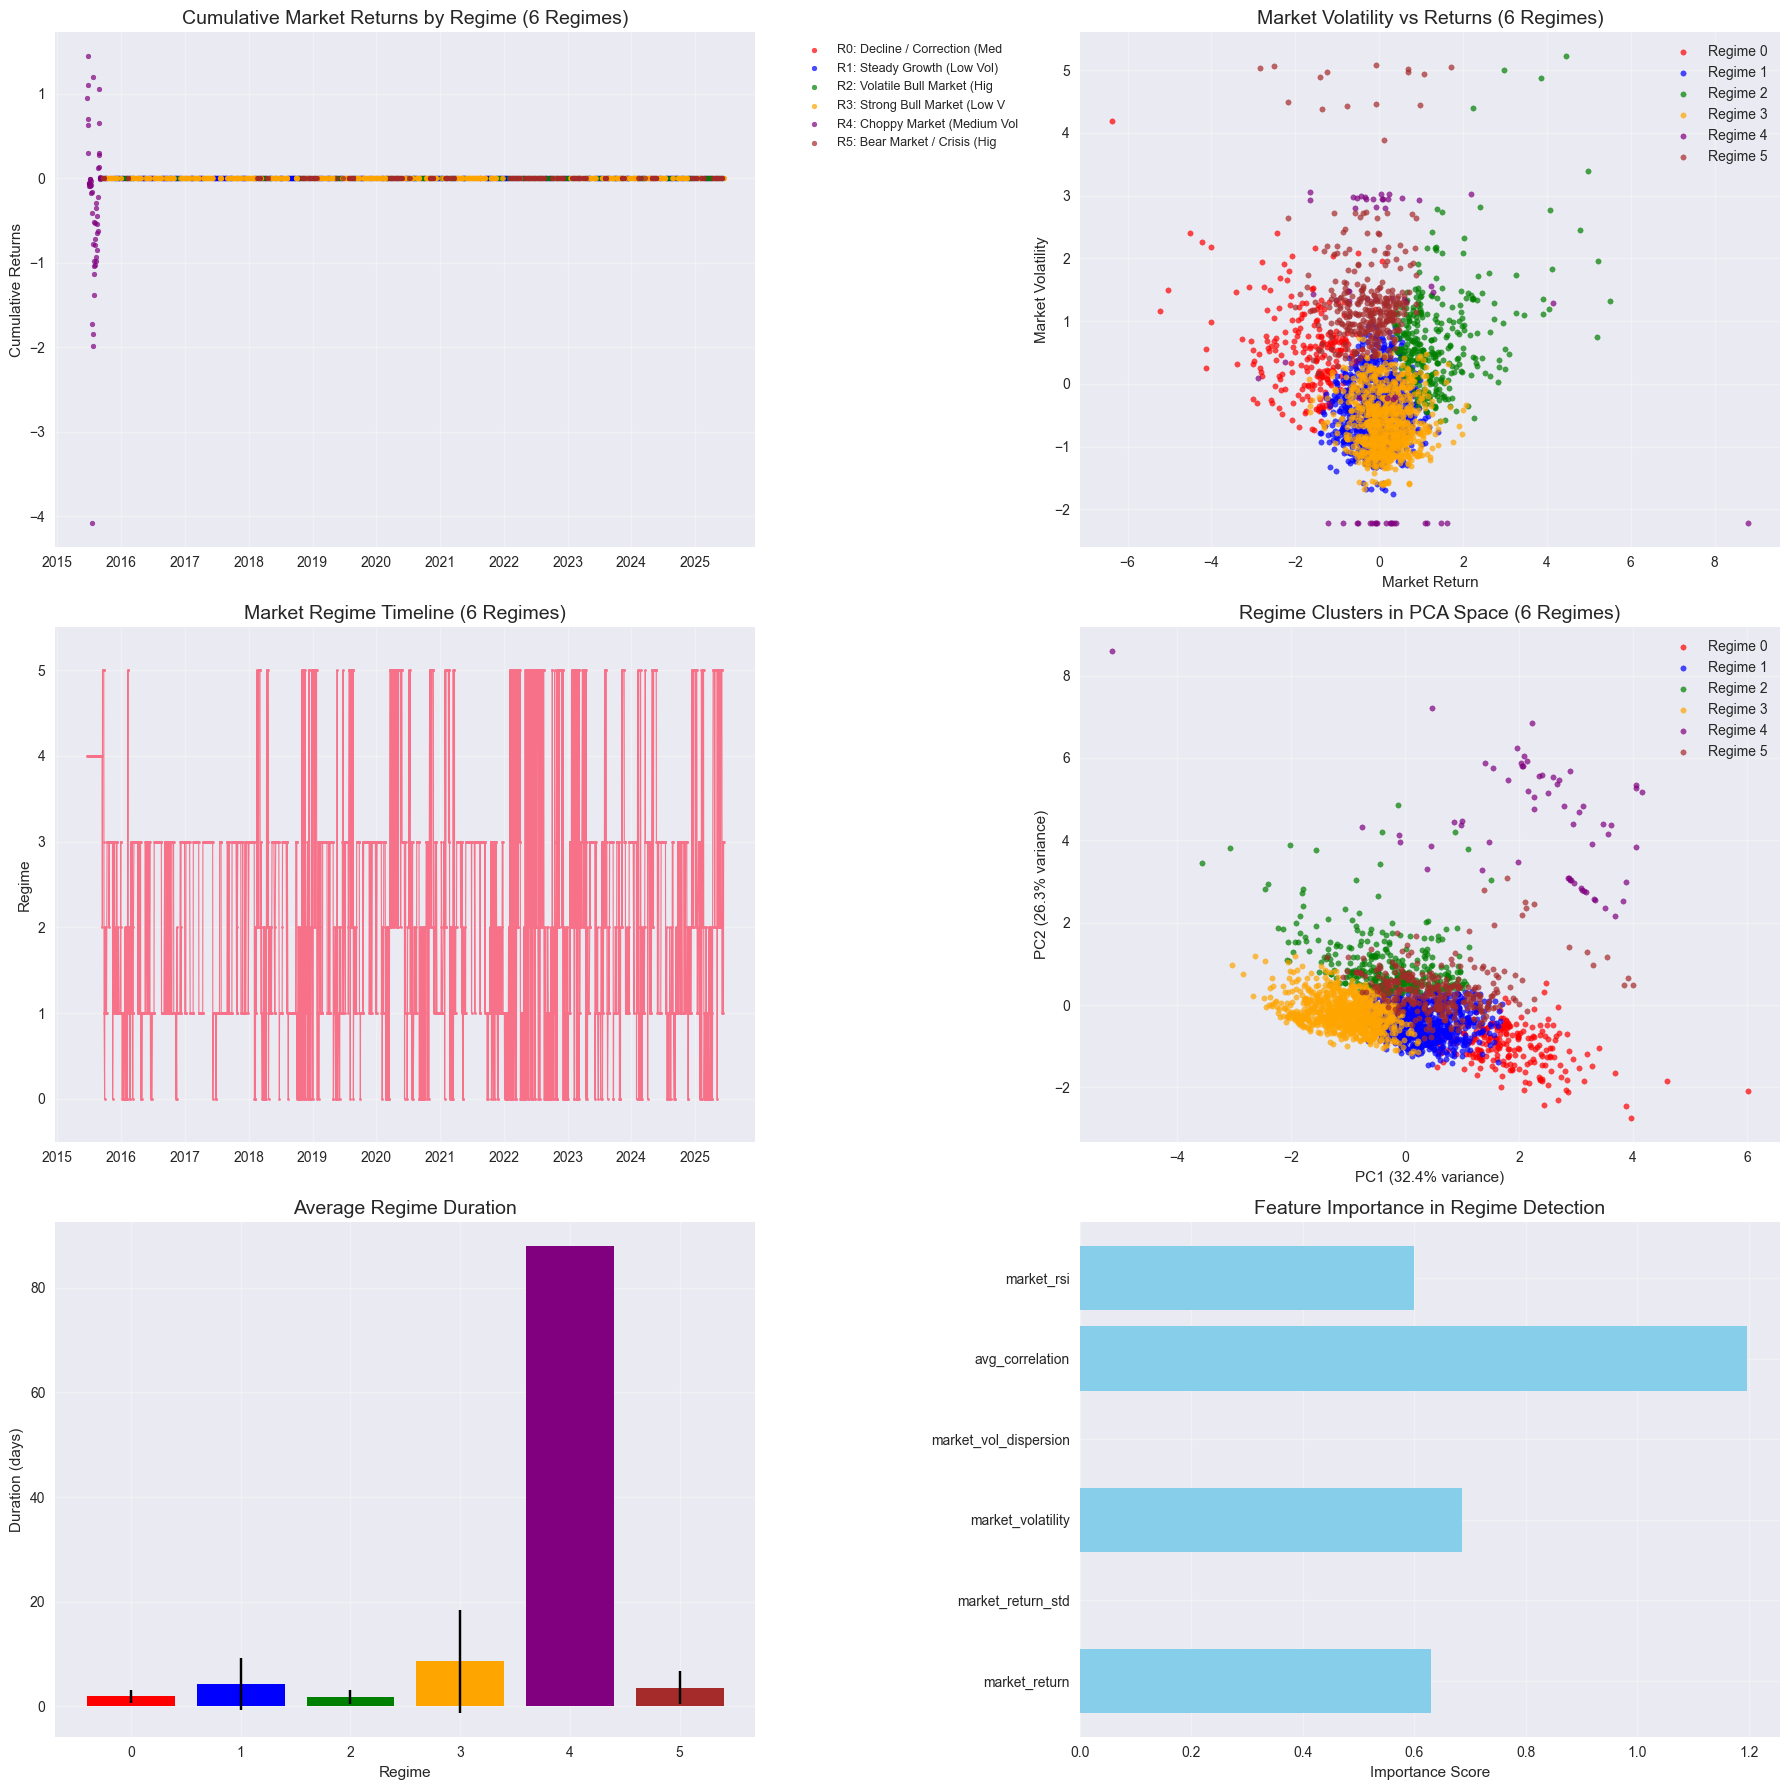


Regime Duration Summary:
             mean       std  count
regime                            
0        1.895604  1.319251    182
1        4.238636  5.017068    264
2        1.822835  1.296129    254
3        8.586957  9.911085    138
4       88.000000       NaN      1
5        3.547619  3.176431    126


In [66]:
fig, axes = plt.subplots(3, 2, figsize=(18, 18))

for i in range(optimal_k):
    mask = regime_df['kmeans_regime'] == i
    axes[0,0].scatter(regime_df[mask].index, regime_df[mask]['market_return_cumulative'], 
                     c=colors[i], label=f'R{i}: {kmeans_labels_dict.get(i, f"Regime {i}")[:25]}', 
                     alpha=0.7, s=12)

axes[0,0].set_title('Cumulative Market Returns by Regime (6 Regimes)', fontsize=14)
axes[0,0].set_ylabel('Cumulative Returns')
axes[0,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
axes[0,0].grid(True, alpha=0.3)

for i in range(optimal_k):
    mask = regime_df['kmeans_regime'] == i
    axes[0,1].scatter(regime_df[mask]['market_return'], regime_df[mask]['market_volatility'], 
                     c=colors[i], label=f'Regime {i}', alpha=0.7, s=15)

axes[0,1].set_title('Market Volatility vs Returns (6 Regimes)', fontsize=14)
axes[0,1].set_xlabel('Market Return')
axes[0,1].set_ylabel('Market Volatility')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

regime_timeline = regime_df['kmeans_regime'].copy()
axes[1,0].plot(regime_timeline.index, regime_timeline, 'o-', markersize=2, linewidth=0.8)
axes[1,0].set_title('Market Regime Timeline (6 Regimes)', fontsize=14)
axes[1,0].set_ylabel('Regime')
axes[1,0].set_ylim(-0.5, 5.5)
axes[1,0].grid(True, alpha=0.3)

pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

for i in range(optimal_k):
    mask = regime_df['kmeans_regime'] == i
    axes[1,1].scatter(pca_features[mask, 0], pca_features[mask, 1], 
                     c=colors[i], label=f'Regime {i}', alpha=0.7, s=15)

axes[1,1].set_title('Regime Clusters in PCA Space (6 Regimes)', fontsize=14)
axes[1,1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
axes[1,1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

regime_changes = regime_df['kmeans_regime'].diff() != 0
regime_periods = []
current_regime = regime_df['kmeans_regime'].iloc[0]
start_date = regime_df.index[0]

for i, (date, regime) in enumerate(regime_df['kmeans_regime'].items()):
    if regime != current_regime or i == len(regime_df) - 1:
        duration = (date - start_date).days
        regime_periods.append({'regime': current_regime, 'duration': duration, 'start': start_date, 'end': date})
        current_regime = regime
        start_date = date

regime_duration_df = pd.DataFrame(regime_periods)
regime_duration_summary = regime_duration_df.groupby('regime')['duration'].agg(['mean', 'std', 'count'])

axes[2,0].bar(regime_duration_summary.index, regime_duration_summary['mean'], 
              yerr=regime_duration_summary['std'], capsize=5, color=colors)
axes[2,0].set_title('Average Regime Duration', fontsize=14)
axes[2,0].set_xlabel('Regime')
axes[2,0].set_ylabel('Duration (days)')
axes[2,0].grid(True, alpha=0.3)

feature_importance = np.abs(kmeans.cluster_centers_).mean(axis=0)
feature_names = feature_columns

axes[2,1].barh(feature_names, feature_importance, color='skyblue')
axes[2,1].set_title('Feature Importance in Regime Detection', fontsize=14)
axes[2,1].set_xlabel('Importance Score')
axes[2,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nRegime Duration Summary:")
print(regime_duration_summary)

=== REGIME PREDICTION CONFIDENCE ===
Current regime confidence: 0.912
Average confidence by regime:
  Regime 0: 0.877
  Regime 1: 0.909
  Regime 2: 0.874
  Regime 3: 0.911
  Regime 4: 0.696
  Regime 5: 0.878


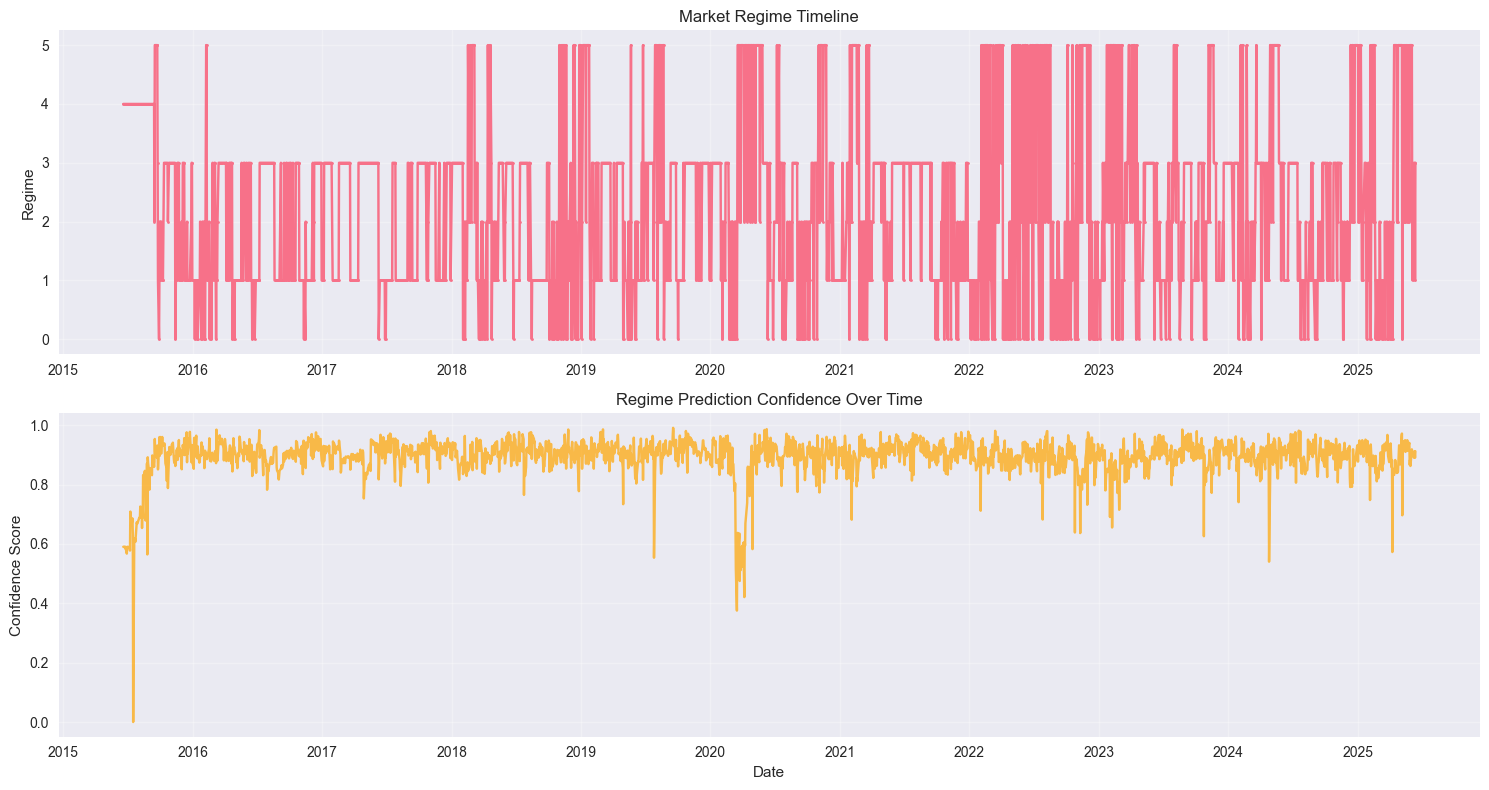


Low confidence periods (< 0.5): 4 days
High confidence periods (> 0.8): 2397 days


In [67]:
def calculate_regime_confidence(model, data, regime_labels):
    
    distances = model.transform(data)
    min_distances = distances.min(axis=1)
    
    max_distance = min_distances.max()
    confidence_scores = 1 - (min_distances / max_distance)
    
    return confidence_scores

confidence_scores = calculate_regime_confidence(kmeans, scaled_features, kmeans_labels)
regime_df['confidence'] = confidence_scores

print("=== REGIME PREDICTION CONFIDENCE ===")
print(f"Current regime confidence: {confidence_scores[-1]:.3f}")
print(f"Average confidence by regime:")
confidence_by_regime = regime_df.groupby('kmeans_regime')['confidence'].mean()
for regime, conf in confidence_by_regime.items():
    print(f"  Regime {regime}: {conf:.3f}")

plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(regime_df.index, regime_df['kmeans_regime'], 'o-', markersize=2)
plt.title('Market Regime Timeline')
plt.ylabel('Regime')
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(regime_df.index, regime_df['confidence'], color='orange', alpha=0.7)
plt.title('Regime Prediction Confidence Over Time')
plt.xlabel('Date')
plt.ylabel('Confidence Score')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nLow confidence periods (< 0.5): {(confidence_scores < 0.5).sum()} days")
print(f"High confidence periods (> 0.8): {(confidence_scores > 0.8).sum()} days")

In [68]:
import pickle
import os

models_dir = "../models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

model_artifacts = {
    'kmeans_model': kmeans,
    'gmm_model': gmm,
    'scaler': scaler,
    'feature_columns': feature_columns,
    'regime_labels': kmeans_labels_dict,
    'optimal_k': optimal_k,
    'stocks': stocks
}

model_path = os.path.join(models_dir, "market_regime_model.pkl")
with open(model_path, 'wb') as f:
    pickle.dump(model_artifacts, f)

print(f"✅ Market regime model saved to: {model_path}")
print(f"Model contains: {list(model_artifacts.keys())}")

✅ Market regime model saved to: ../models\market_regime_model.pkl
Model contains: ['kmeans_model', 'gmm_model', 'scaler', 'feature_columns', 'regime_labels', 'optimal_k', 'stocks']


In [69]:
def track_regime_changes(stocks, model_path="../models/market_regime_model.pkl", days=30):

    with open(model_path, 'rb') as f:
        model_artifacts = pickle.load(f)
    
    kmeans_model = model_artifacts['kmeans_model']
    scaler = model_artifacts['scaler']
    feature_columns = model_artifacts['feature_columns']
    regime_labels = model_artifacts['regime_labels']
    
    regime_definitions = {
        0: {
            "label": regime_labels.get(0, "Regime 0"),
            "description": "Market characterized by specific return and volatility patterns",
            "characteristics": [],
            "typical_conditions": "Varies based on trained model"
        },
        1: {
            "label": regime_labels.get(1, "Regime 1"),
            "description": "Market characterized by specific return and volatility patterns",
            "characteristics": [],
            "typical_conditions": "Varies based on trained model"
        },
        2: {
            "label": regime_labels.get(2, "Regime 2"),
            "description": "Market characterized by specific return and volatility patterns",
            "characteristics": [],
            "typical_conditions": "Varies based on trained model"
        },
        3: {
            "label": regime_labels.get(3, "Regime 3"),
            "description": "Market characterized by specific return and volatility patterns",
            "characteristics": [],
            "typical_conditions": "Varies based on trained model"
        },
        4: {
            "label": regime_labels.get(4, "Regime 4"),
            "description": "Market characterized by specific return and volatility patterns",
            "characteristics": [],
            "typical_conditions": "Varies based on trained model"
        },
        5: {
            "label": regime_labels.get(5, "Regime 5"),
            "description": "Market characterized by specific return and volatility patterns",
            "characteristics": [],
            "typical_conditions": "Varies based on trained model"
        }
    }
    
    enhanced_definitions = {
        "Strong Bull Market (Low Vol)": {
            "description": "Sustained upward trend with low volatility",
            "characteristics": [
                "📈 Consistent positive returns",
                "📉 Low market volatility",
                "🎯 High investor confidence",
                "💰 Strong fundamentals"
            ],
            "typical_conditions": "Economic growth, low interest rates, positive sentiment",
            "investment_implications": "Growth strategies, momentum investing",
            "risk_level": "Low to Medium"
        },
        "Volatile Bull Market (High Vol)": {
            "description": "Upward trend with high volatility and uncertainty",
            "characteristics": [
                "📈 Positive returns with high swings",
                "📊 Elevated volatility",
                "⚡ Market uncertainty",
                "🎢 Emotional trading"
            ],
            "typical_conditions": "Economic uncertainty, mixed signals, speculation",
            "investment_implications": "Careful timing, risk management essential",
            "risk_level": "Medium to High"
        },
        "Steady Growth (Low Vol)": {
            "description": "Moderate upward trend with stable conditions",
            "characteristics": [
                "📊 Moderate positive returns",
                "📉 Low volatility",
                "⚖️ Balanced market conditions",
                "🔄 Steady progression"
            ],
            "typical_conditions": "Stable economy, predictable growth, balanced sentiment",
            "investment_implications": "Long-term strategies, dividend focus",
            "risk_level": "Low"
        },
        "Choppy Market (Medium Vol)": {
            "description": "Sideways movement with moderate volatility",
            "characteristics": [
                "↔️ Range-bound trading",
                "📊 Moderate volatility",
                "🔄 Mixed signals",
                "⚖️ Indecisive market"
            ],
            "typical_conditions": "Economic transition, mixed data, consolidation",
            "investment_implications": "Range trading, sector rotation",
            "risk_level": "Medium"
        },
        "Bear Market / Crisis (High Vol)": {
            "description": "Significant decline with high volatility and fear",
            "characteristics": [
                "📉 Sustained negative returns",
                "📊 Very high volatility",
                "😰 Market panic",
                "🚨 Crisis conditions"
            ],
            "typical_conditions": "Economic recession, crisis events, panic selling",
            "investment_implications": "Defensive strategies, cash preservation",
            "risk_level": "Very High"
        },
        "Decline / Correction (Medium Vol)": {
            "description": "Controlled decline with moderate volatility",
            "characteristics": [
                "📉 Negative returns",
                "📊 Moderate volatility",
                "🔄 Orderly decline",
                "⚖️ Controlled selling"
            ],
            "typical_conditions": "Market correction, profit-taking, rebalancing",
            "investment_implications": "Value hunting, gradual re-entry",
            "risk_level": "Medium to High"
        }
    }
    
    end_date = pd.Timestamp.now().strftime('%Y-%m-%d')
    start_date = (pd.Timestamp.now() - pd.Timedelta(days=days + 100)).strftime('%Y-%m-%d')
    
    print(f"📊 Downloading data for regime tracking...")
    
    recent_stock_data = {}
    for symbol in stocks:
        data = yf.download(symbol, start=start_date, end=end_date, progress=False)
        if len(data) > 0:
            recent_stock_data[symbol] = data
    
    print(f"✅ Downloaded data for {len(recent_stock_data)} stocks")
    
    recent_indicators = {}
    for symbol, data in recent_stock_data.items():
        indicators = calculate_technical_indicators(data)
        recent_indicators[symbol] = indicators
    
    recent_market_df = create_market_features(recent_indicators)
    recent_features_df = recent_market_df[feature_columns].dropna()
    
    recent_scaled_features = scaler.transform(recent_features_df)
    predictions = kmeans_model.predict(recent_scaled_features)
    
    results_df = pd.DataFrame({
        'date': recent_features_df.index,
        'regime': predictions,
        'regime_label': [regime_labels.get(r, f"Regime {r}") for r in predictions]
    })
    
    distances = kmeans_model.transform(recent_scaled_features)
    confidences = 1 / (1 + distances.min(axis=1))
    results_df['confidence'] = confidences
    
    results_df['daily_return'] = recent_market_df['market_return'].values[:len(results_df)]
    results_df['volatility'] = recent_market_df['market_volatility'].values[:len(results_df)]
    results_df['rsi'] = recent_market_df['market_rsi'].values[:len(results_df)]
    
    results_df = results_df.tail(days).reset_index(drop=True)
    
    
    print(f"\n📅 Last 10 Trading Days:")
    recent_summary = results_df[['date', 'regime_label', 'confidence', 'daily_return']].tail(10)
    recent_summary['daily_return_pct'] = recent_summary['daily_return'] * 100
    
    for _, row in recent_summary.iterrows():
        confidence_emoji = "🟢" if row['confidence'] > 0.7 else "🟡" if row['confidence'] > 0.5 else "🔴"
        return_emoji = "📈" if row['daily_return'] > 0 else "📉" if row['daily_return'] < 0 else "➡️"
        print(f"{row['date'].strftime('%Y-%m-%d')}: {row['regime_label'][:25]} {confidence_emoji} "
              f"(Conf: {row['confidence']:.2f}) {return_emoji} ({row['daily_return_pct']:.2f}%)")
    
    print(f"\n📊 Regime Distribution (Last {days} days):")
    regime_counts = results_df['regime_label'].value_counts()
    total_days = len(results_df)
    
    for regime, count in regime_counts.items():
        percentage = (count / total_days) * 100
        avg_return = results_df[results_df['regime_label'] == regime]['daily_return'].mean() * 100
        avg_confidence = results_df[results_df['regime_label'] == regime]['confidence'].mean()        
        performance_emoji = "🟢" if avg_return > 0.1 else "🔴" if avg_return < -0.1 else "🟡"
        confidence_emoji = "🎯" if avg_confidence > 0.7 else "⚠️"
        
        print(f"  {performance_emoji} {regime}: {count} days ({percentage:.1f}%) "
              f"| Avg Return: {avg_return:.2f}% {confidence_emoji} Avg Conf: {avg_confidence:.2f}")
    
    current_regime = results_df.iloc[-1]
    print(f"\n🔮 CURRENT REGIME STATUS")
    print(f"Current Regime: {current_regime['regime_label']}")
    print(f"Confidence: {current_regime['confidence']:.3f}")
    print(f"Latest Return: {current_regime['daily_return']*100:.2f}%")
    
    regime_changes = (results_df['regime'] != results_df['regime'].shift(1)).sum()
    print(f"\n📊 REGIME STABILITY")
    print(f"Regime changes in last {days} days: {regime_changes}")
    print(f"Stability score: {(1 - regime_changes/days)*100:.1f}%")
    
    if regime_changes > days * 0.3:  # More than 30% regime changes
        print("⚠️ High regime volatility detected - market conditions are changing frequently")
    elif regime_changes < days * 0.1:  # Less than 10% regime changes
        print("✅ Stable regime environment - consistent market conditions")
    else:
        print("📊 Moderate regime stability - normal market transitions")
    
    return results_df

In [70]:
regime_history = track_regime_changes(stocks = ['AAPL'], days=30)

📊 Downloading data for regime tracking...
✅ Downloaded data for 1 stocks

📅 Last 10 Trading Days:
2025-06-02: Steady Growth (Low Vol) 🔴 (Conf: 0.48) 📈 (0.42%)
2025-06-03: Steady Growth (Low Vol) 🔴 (Conf: 0.48) 📈 (0.78%)
2025-06-04: Steady Growth (Low Vol) 🟡 (Conf: 0.51) 📉 (-0.22%)
2025-06-05: Steady Growth (Low Vol) 🔴 (Conf: 0.46) 📉 (-1.08%)
2025-06-06: Volatile Bull Market (Hig 🔴 (Conf: 0.48) 📈 (1.64%)
2025-06-09: Steady Growth (Low Vol) 🔴 (Conf: 0.50) 📉 (-1.21%)
2025-06-10: Steady Growth (Low Vol) 🟢 (Conf: 0.71) 📈 (0.61%)
2025-06-11: Steady Growth (Low Vol) 🔴 (Conf: 0.50) 📉 (-1.92%)
2025-06-12: Steady Growth (Low Vol) 🟢 (Conf: 0.80) 📈 (0.21%)
2025-06-13: Steady Growth (Low Vol) 🟡 (Conf: 0.53) 📉 (-1.38%)

📊 Regime Distribution (Last 30 days):
  🔴 Bear Market / Crisis (High Vol): 13 days (43.3%) | Avg Return: -0.30% ⚠️ Avg Conf: 0.49
  🔴 Steady Growth (Low Vol): 11 days (36.7%) | Avg Return: -0.46% ⚠️ Avg Conf: 0.55
  🟢 Volatile Bull Market (High Vol): 3 days (10.0%) | Avg Return: 3.49

In [71]:
regime_history

,date,regime,regime_label,confidence,daily_return,volatility,rsi
0,2025-05-02,4,Choppy Market (Medium Vol),0.191888,-0.037362,0.047138,57.614221
1,2025-05-05,5,Bear Market / Crisis (High Vol),0.262556,-0.031458,0.044533,46.323681
2,2025-05-06,5,Bear Market / Crisis (High Vol),0.305308,-0.001911,0.043542,46.323667
3,2025-05-07,5,Bear Market / Crisis (High Vol),0.334030,-0.011385,0.041792,52.262333
4,2025-05-08,5,Bear Market / Crisis (High Vol),0.537129,0.006319,0.023826,50.602986
5,2025-05-09,5,Bear Market / Crisis (High Vol),0.524032,0.005266,0.021655,56.795755
6,2025-05-12,2,Volatile Bull Market (High Vol),0.321579,0.063146,0.024192,62.455789
7,2025-05-13,5,Bear Market / Crisis (High Vol),0.520212,0.010152,0.023854,60.069430
8,2025-05-14,5,Bear Market / Crisis (High Vol),0.677522,-0.002818,0.023865,55.354275
9,2025-05-15,5,Bear Market / Crisis (High Vol),0.566451,-0.004145,0.021846,53.093817
